In [3]:
import cv2
import numpy as np
from numpy.fft import fft2, ifft2
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral

In [4]:
# GLOBAL SETUPS
TEMPLATE_BANK_SIZE = 8
NCC_THRESHOLD = 0.5
template_bank = []

##
## Localization: Template Matching + Bank

In [5]:
def masked_ncc_fft(search_image, template, mask):
    """
    Compute masked normalized cross-correlation (NCC) between a search image and a template
    using FFT-based convolution for efficiency.

    Args:
        search_image (np.ndarray): Grayscale search region image of shape (H, W).
        template (np.ndarray): Grayscale template image of shape (h, w).
        mask (np.ndarray): Binary mask of same shape as template; 1 indicates valid pixels,
                           0 indicates pixels to ignore in matching.

    Returns:
        tuple:
            ncc_map (np.ndarray): Valid NCC map of shape (H - h + 1, W - w + 1).
            max_val (float): Maximum NCC score found.
            max_loc (tuple): (x, y) location of the maximum NCC score in ncc_map.
    """
    # Convert inputs to float32 for numerical precision and FFT compatibility
    search_f = search_image.astype(np.float32)
    template_f = template.astype(np.float32)
    mask_f = mask.astype(np.float32)

    H, W = search_f.shape
    h, w = template_f.shape

    # Prepare padded arrays matching search image size
    template_masked = template_f * mask_f
    padded_template = np.zeros_like(search_f)
    padded_mask = np.zeros_like(search_f)
    padded_template[:h, :w] = template_masked
    padded_mask[:h, :w] = mask_f

    # Compute FFTs
    fft_search = fft2(search_f)
    fft_template = fft2(padded_template)
    fft_mask = fft2(padded_mask)
    fft_search_sq = fft2(search_f ** 2)

    # Compute numerator and local sums via inverse FFT
    numerator = ifft2(fft_search * np.conj(fft_template)).real
    sum_search = ifft2(fft_search * np.conj(fft_mask)).real
    sum_search_sq = ifft2(fft_search_sq * np.conj(fft_mask)).real
    sum_mask = ifft2(fft_mask * np.conj(fft_mask)).real

    # Precompute template sums
    sum_template = np.sum(template_masked)
    sum_template_sq = np.sum(template_masked ** 2)

    # Compute denominator for NCC formula
    denom = (sum_template_sq - (sum_template ** 2) / (sum_mask + 1e-8)) * \
            (sum_search_sq - (sum_search ** 2) / (sum_mask + 1e-8))
    denom = np.maximum(denom, 0)
    denom = np.sqrt(denom)

    # Compute normalized cross-correlation map
    with np.errstate(divide='ignore', invalid='ignore'):
        ncc = (numerator - (sum_search * sum_template / (sum_mask + 1e-8))) / denom
        ncc[sum_mask < 1] = 0  # Invalidate locations with insufficient mask support

    # Extract valid NCC region (where template fully fits inside search image)
    valid_h = H - h + 1
    valid_w = W - w + 1
    ncc_valid = ncc[:valid_h, :valid_w]

    # Find max NCC value and location
    _, max_val, _, max_loc = cv2.minMaxLoc(ncc_valid)
    return ncc_valid, max_val, max_loc


In [18]:
def get_patch(frame_gray, template_coords, padding=10):
    """
    Extract a padded region (patch) from a grayscale frame.

    Args:
        frame_gray (np.ndarray): Grayscale frame image.
        template_coords (tuple): Bounding box (x, y, w, h) of the template.
        padding (int): Number of pixels to pad around the box.

    Returns:
        tuple: (patch image, top-left patch coordinates)
    """
    x, y, w, h = template_coords
    x_start = max(0, x - padding)
    y_start = max(0, y - padding)
    x_end = min(frame_gray.shape[1], x + w + padding)
    y_end = min(frame_gray.shape[0], y + h + padding)
    
    return frame_gray[y_start:y_end, x_start:x_end], (x_start, y_start)


def display_patch(patch, frame_idx, padding):
    """
    Display a grayscale patch with annotation.

    Args:
        patch (np.ndarray): Image patch.
        frame_idx (int): Index of the frame.
        padding (int): Padding used to extract the patch.
    """
    plt.figure(figsize=(4, 4))
    plt.imshow(patch, cmap='gray')
    plt.title(f"Patch (Frame {frame_idx}, Padding {padding})")
    plt.axis('off')
    plt.show()


def rescale(template, template_mask, scale):
    """
    Rescale both template and its mask by a given factor.

    Args:
        template (np.ndarray): Template image.
        template_mask (np.ndarray): Binary mask for the template.
        scale (float): Scaling factor.

    Returns:
        tuple: (rescaled template, rescaled mask)
    """
    new_w = max(1, int(template.shape[1] * scale))
    new_h = max(1, int(template.shape[0] * scale))
    scaled_template = cv2.resize(template, (new_w, new_h), interpolation=cv2.INTER_AREA)
    scaled_mask = cv2.resize(template_mask, (new_w, new_h), interpolation=cv2.INTER_NEAREST)
    return scaled_template, scaled_mask


def evaluate_templates(min_similarity, search_patch, scale, best_score, best_box,
                       best_template, best_mask, best_scale, all_boxes, all_scores):
    """
    Evaluate all templates in the bank at a given scale and update best match if needed.

    Args:
        min_similarity (float): Score threshold to consider updating the bank.
        search_patch (np.ndarray): Grayscale image region to match against.
        scale (float): Scale to apply to templates.
        best_score (float): Current best similarity score.
        best_box (tuple): Current best bounding box.
        best_template (np.ndarray): Current best template image.
        best_mask (np.ndarray): Current best template mask.
        best_scale (float): Current best matching scale.
        all_boxes (list): Accumulator for all bounding boxes.
        all_scores (list): Accumulator for all scores.

    Returns:
        tuple: (template_updated, best_score, best_box, best_template, best_mask,
                best_scale, all_boxes, all_scores)
    """
    H, W = search_patch.shape
    template_updated = False

    for template_img, template_mask in template_bank:
        if scale != 1.0:
            template_img, template_mask = rescale(template_img, template_mask, scale)

        h, w = template_img.shape
        if H < h or W < w:
            continue
        
        _, score, loc = masked_ncc_fft(search_patch, template_img, template_mask)

        if score > best_score:
            best_score = score
            best_box = (*loc, w, h)
            best_template = template_img
            best_mask = template_mask
            best_scale = scale

        all_boxes.append((*loc, w, h))
        all_scores.append(score)

        if score > min_similarity and scale != 1.0:
            if best_template is not None and best_mask is not None:
                add_to_template_bank(best_template, best_mask)
                template_updated = True
            break

    return template_updated, best_score, best_box, best_template, best_mask, best_scale, all_boxes, all_scores


def find_best_match(search_patch, min_similarity=0.8, scales=[0.9, 0.95, 1.05, 1.1]):
    """
    Find the best matching template (multi-scale) within a search patch.

    Args:
        search_patch (np.ndarray): Grayscale region to match against.
        min_similarity (float): Minimum similarity threshold to avoid scaling.
        scales (list): List of scale factors to evaluate.

    Returns:
        tuple: (template_updated, all_boxes, all_scores, best_score,
                best_box, best_template, best_mask, best_scale)
    """
    best_score = -1
    best_box = None
    best_template = None
    best_mask = None
    best_scale = 1.0
    all_boxes, all_scores = [], []

    print("[find_best_match] Matching with templates in template bank...")
    result = evaluate_templates(min_similarity, search_patch, 1.0, best_score,
                                best_box, best_template, best_mask, best_scale,
                                all_boxes, all_scores)
    (template_updated, best_score, best_box, best_template,
     best_mask, best_scale, all_boxes, all_scores) = result

    print(f"[find_best_match] Current best NCC score: {best_score:.4f}")
    if best_score < min_similarity:
        for scale in scales:
            result = evaluate_templates(min_similarity, search_patch, scale, best_score,
                                        best_box, best_template, best_mask, best_scale,
                                        all_boxes, all_scores)
            (template_updated, best_score, best_box, best_template,
             best_mask, best_scale, all_boxes, all_scores) = result
            if best_score >= min_similarity:
                break

    if best_box is None:
        best_box = (0, 0, 0, 0)

    return template_updated, all_boxes, all_scores, best_score, best_box, best_template, best_mask, best_scale


def update_template_from_box(frame_gray, box):
    """
    Create a new template and binary mask from a specified region.

    Args:
        frame_gray (np.ndarray): Grayscale frame image.
        box (tuple): Bounding box (x, y, w, h) for the region.

    Returns:
        tuple: (cropped template, binary mask from Otsu thresholding)
    """
    x, y, w, h = box
    new_template = frame_gray[y:y+h, x:x+w]
    _, new_mask = cv2.threshold(new_template, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return new_template, new_mask


def add_to_template_bank(template, mask):
    """
    Add a new template to the global template bank, maintaining a fixed max size.

    Args:
        template (np.ndarray): Template image to store.
        mask (np.ndarray): Corresponding binary mask.
    """
    global template_bank, TEMPLATE_BANK_SIZE
    template_bank.append((template, mask))
    if len(template_bank) > TEMPLATE_BANK_SIZE:
        template_bank.pop(0)


def apply_nms(boxes, scores, threshold, nms_thresh):
    """
    Apply Non-Maximum Suppression to a set of bounding boxes and scores.

    Args:
        boxes (list): List of bounding boxes.
        scores (list): Confidence scores corresponding to the boxes.
        threshold (float): Score threshold for consideration.
        nms_thresh (float): Overlap threshold for NMS.

    Returns:
        list: Indices of selected boxes after NMS.
    """
    if not boxes:
        return []

    indices = cv2.dnn.NMSBoxes(boxes, scores, threshold, nms_thresh)
    if len(indices) == 0:
        return []

    return [i[0] if isinstance(i, (list, np.ndarray)) else i for i in indices]


def get_template_index(template, template_bank):
    """
    Get index of a template in the bank using array equality.

    Args:
        template (np.ndarray): Template to search for.
        template_bank (list): List of (template, mask) tuples.

    Returns:
        int or None: Index if found, else None.
    """
    for i, (t, _) in enumerate(template_bank):
        if np.array_equal(t, template):
            return i
    return None


def visualize_template_bank(template_bank, current_index=None, max_per_row=5,
                            figsize=(15, 5), cmap='gray'):
    """
    Visualize all templates and masks in the bank using matplotlib.

    Args:
        template_bank (list): List of (template, mask) tuples.
        current_index (int): Index to highlight (optional).
        max_per_row (int): Max number of images per row.
        figsize (tuple): Figure size for display.
        cmap (str): Color map for grayscale display.
    """
    n = len(template_bank)
    if n == 0:
        print("⚠️ Template bank is empty.")
        return

    cols = min(n, max_per_row)
    rows = (n + cols - 1) // cols

    plt.figure(figsize=figsize)
    for i, (template, mask) in enumerate(template_bank):
        ax = plt.subplot(rows, cols, i + 1)

        if mask.dtype != np.uint8:
            mask = mask.astype(np.uint8)
        if mask.shape != template.shape:
            mask = cv2.resize(mask, (template.shape[1], template.shape[0]), interpolation=cv2.INTER_NEAREST)

        masked = cv2.bitwise_and(template, template, mask=mask)
        overlay = np.stack([masked]*3, axis=-1)
        overlay[mask == 0] = [255, 0, 0]

        ax.imshow(overlay)
        title = f"Template {i}"
        if i == current_index:
            title += " (Current)"
            ax.set_title(title, color='red')
            for spine in ax.spines.values():
                spine.set_edgecolor('red')
                spine.set_linewidth(2)
        else:
            ax.set_title(title)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

##
## Mask Refinement: Similarity with Previous Foreground (nanti separate file???)

In [7]:
def refine_mask(frame_roi_gray, template_gray, template_mask,
                similarity_threshold=0.15, dissimilarity_threshold=0.3):
    """
    Produce a rough initial mask by comparing grayscale values between
    current ROI and template. Used as unary term for CRF.

    Args:
        frame_roi_gray (np.ndarray): Grayscale current ROI.
        template_gray (np.ndarray): Grayscale template.
        template_mask (np.ndarray): Binary mask for template (1=fg).
        similarity_threshold (float): Intensity difference for foreground match.
        dissimilarity_threshold (float): Threshold to suppress clear background.

    Returns:
        np.ndarray: Rough binary mask (uint8, values 0 or 1).
    """
    # Resize template and mask to match current ROI
    h, w = frame_roi_gray.shape
    template_gray = cv2.resize(template_gray, (w, h), interpolation=cv2.INTER_LINEAR)
    template_mask = cv2.resize(template_mask, (w, h), interpolation=cv2.INTER_NEAREST)

    # Normalize
    frame_norm = frame_roi_gray.astype(np.float32) / 255.0
    template_norm = template_gray.astype(np.float32) / 255.0

    # Compute difference
    diff = np.abs(frame_norm - template_norm)

    # Foreground if similar *and* was previously foreground
    fg = ((diff < similarity_threshold) & (template_mask > 0)).astype(np.uint8)

    # Suppress background if very dissimilar
    bg = (diff > dissimilarity_threshold).astype(np.uint8)
    fg[bg == 1] = 0

    return fg


# ========== USE CRF ============ #
def crf_refine(frame_bgr, mask):
    """
    Refine binary mask with DenseCRF.
    
    Args:
        frame_bgr (np.ndarray): BGR image (uint8).
        mask (np.ndarray): Binary mask (0 or 1).
    
    Returns:
        np.ndarray: Refined binary mask (0 or 1).
    """
    frame_bgr = frame_bgr.copy()
    
    h, w = mask.shape
    n_labels = 2  # background=0, foreground=1

    labels = mask.astype(np.uint32)

    d = dcrf.DenseCRF2D(w, h, n_labels)
    unary = unary_from_labels(labels, n_labels, gt_prob=0.7, zero_unsure=False)
    d.setUnaryEnergy(unary)

    # Smoothness
    d.addPairwiseGaussian(sxy=3, compat=3)

    # Color-based edge alignment
    d.addPairwiseBilateral(sxy=50, srgb=13, rgbim=frame_bgr, compat=10)

    Q = d.inference(5)
    refined = np.argmax(Q, axis=0).reshape((h, w))

    return refined.astype(np.uint8)


##
## Background Blurring

In [9]:
def blur_background(image: np.ndarray, mask: np.ndarray, ksize=(33, 33), sigma=0, feather_radius=15) -> np.ndarray:
    """
    Blurs the background of the image while keeping the foreground sharp,
    using a feathered mask for smooth blending.

    Args:
        image (np.ndarray): RGB image (H, W, 3).
        mask (np.ndarray): Binary mask (H, W), foreground=1 or 255.
        ksize (tuple, optional): Kernel size for Gaussian blur. Defaults to (33, 33).
        sigma (int, optional): Gaussian blur sigma for background blur. Defaults to 0.
        feather_radius (int, optional): Radius in pixels to feather mask edges. Defaults to 15.

    Returns:
        np.ndarray: Image with blurred background and feathered transition.
    """

    # Normalize mask to 0..1 float
    mask_norm = (mask > 0).astype(np.float32)

    # Feather mask by applying Gaussian blur on the binary mask edges
    # This creates a smooth transition (values between 0 and 1)
    feathered_mask = cv2.GaussianBlur(mask_norm, (feather_radius*2+1, feather_radius*2+1), 0)

    # Blur the whole image
    blurred = cv2.GaussianBlur(image, ksize, sigma)

    # Blend images using the feathered mask as weights per pixel
    # Foreground = feathered_mask close to 1 -> mostly sharp image
    # Background = feathered_mask close to 0 -> mostly blurred image
    feathered_mask_3c = np.repeat(feathered_mask[:, :, None], 3, axis=2)

    combined = (image.astype(np.float32) * feathered_mask_3c +
                blurred.astype(np.float32) * (1 - feathered_mask_3c))

    return combined.astype(np.uint8)


##
## Utility Functions

In [10]:
def read_video_first_frame(video_path):
    """
    Read the first frame of a video.

    Args:
        video_path (str): Path to the input video file.

    Returns:
        tuple: (cv2.VideoCapture object, first frame as np.ndarray, success flag as bool).
               Returns (None, None, None) if the video cannot be read.
    """
    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    if not ret:
        print("Cannot read video.")
        cap.release()
        return None, None, None
    return cap, frame, ret


def load_template(initial_template_path, frame_gray):
    """
    Load and extract the non-zero region of a grayscale template from a frame.

    Args:
        initial_template_path (str): Path to the grayscale template image.
        frame_gray (np.ndarray): Grayscale frame from which to extract the region.

    Returns:
        tuple: (cropped region from frame, cropped template, bounding box as (x, y, w, h)).
               Returns None if template cannot be loaded or contains no non-zero pixels.
    """
    template = cv2.imread(initial_template_path, cv2.IMREAD_GRAYSCALE)
    if template is None:
        print("Template image not found or failed to load.")
        return None

    coords = cv2.findNonZero(template)
    if coords is None:
        print("No non-zero pixels in template.")
        return None

    x, y, w, h = cv2.boundingRect(coords)
    return frame_gray[y:y+h, x:x+w], template[y:y+h, x:x+w], (x, y, w, h)


def setup_video_writer(output_path, frame_shape, fps):
    """
    Initialize a video writer to save processed frames.

    Args:
        output_path (str): File path to save the output video.
        frame_shape (tuple): Shape of the video frame (height, width, channels).
        fps (float): Frames per second for the output video.

    Returns:
        cv2.VideoWriter: Configured video writer object.
    """
    frame_h, frame_w = frame_shape[:2]
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_w, frame_h))
    print(f"💾 Output video will be saved to: {output_path}")
    return out


##
## Main Mask Propagation Program

In [28]:
def highlight_foreground(frame, mask, color=(0, 0, 255), alpha=0.4):
    """
    Overlay a semi-transparent color highlight on the foreground mask.

    Args:
        frame (np.ndarray): BGR image.
        mask (np.ndarray): Binary mask where foreground = 1 or 255.
        color (tuple): BGR color to overlay (default is red).
        alpha (float): Opacity of the overlay (0 = transparent, 1 = solid).
    
    Returns:
        np.ndarray: Frame with foreground highlighted.
    """
    if mask.max() == 1:
        mask = (mask * 255).astype(np.uint8)

    # Create colored overlay
    overlay = np.zeros_like(frame, dtype=np.uint8)
    overlay[:] = color

    # Create 3-channel mask
    mask_3ch = cv2.merge([mask] * 3)

    # Blend only where mask is non-zero
    frame_highlighted = frame.copy()
    frame_highlighted = np.where(mask_3ch > 0,
                                 cv2.addWeighted(frame, 1 - alpha, overlay, alpha, 0),
                                 frame)
    return frame_highlighted


def draw_tracking_box(frame, box):
    """
    Draw a yellow rectangle on the frame at the specified bounding box.

    Args:
        frame (np.ndarray): Image frame to draw on.
        box (tuple): Bounding box as (x, y, w, h).
    """
    x, y, w, h = box
    cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 255), 2)


def display_frame(frame, frame_idx):
    """
    Display a single video frame using matplotlib.

    Args:
        frame (np.ndarray): BGR image frame to display.
        frame_idx (int): Index of the current frame.
    """
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    clear_output(wait=True)
    plt.figure(figsize=(10, 5))
    plt.imshow(frame_rgb)
    plt.title(f"Frame {frame_idx}")
    plt.axis('off')
    plt.show()


def template_difference(template1, template2, threshold):
    """
    Determine if two templates are significantly different based on NMSE.

    Args:
        template1 (np.ndarray): First grayscale template.
        template2 (np.ndarray): Second grayscale template.
        threshold (float): Normalized mean square error threshold.

    Returns:
        bool: True if templates are different beyond threshold.
    """
    if template1.shape != template2.shape:
        return True
    diff = np.mean((template1.astype(np.float32) - template2.astype(np.float32)) ** 2)
    norm = np.mean(template1.astype(np.float32) ** 2)
    nmse = diff / (norm + 1e-8)
    return nmse > threshold


def dynamic_template_matching(video_path, initial_template_path,
                              output_path="../../outputs/dttm_output.mp4",
                              threshold=0.2, nms_thresh=0.3,
                              similarity_threshold=0.3, num_superpixels=200,
                              blur_kernel=(25, 25), blur_sigma=0, feather_radius=15):
    """
    Perform dynamic template matching with mask refinement and background blur.

    Args:
        video_path (str): Path to the input video.
        initial_template_path (str): Path to the segmented template image.
        output_path (str): Path to save the output video.
        threshold (float): Score threshold for match filtering.
        nms_thresh (float): Non-maximum suppression IoU threshold.
        similarity_threshold (float): Threshold for pixel similarity in refinement.
        num_superpixels (int): Number of superpixels for CRF refinement (unused in current scope).
        blur_kernel (tuple): Kernel size for background blur.
        blur_sigma (float): Sigma value for Gaussian blur.
        feather_radius (int): Radius for feathering mask edges.
    """
    padding, max_padding, min_padding, padding_step = 30, 50, 10, 5

    cap, frame, ret = read_video_first_frame(video_path)
    if not ret:
        return

    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    result = load_template(initial_template_path, frame_gray)
    if result is None:
        cap.release()
        return

    template_bg, template, template_coords = result
    template_mask = (template > 0).astype(np.uint8)
    add_to_template_bank(template, template_mask)

    fps = cap.get(cv2.CAP_PROP_FPS) or 30
    out = setup_video_writer(output_path, frame.shape, fps)

    frame_idx = 0

    while True:
        if frame_idx != 0:
            ret, frame = cap.read()
            if not ret:
                print("📽 Video ended.")
                break
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        search_patch, patch_loc = get_patch(frame_gray, template_coords, padding)
        template_updated, boxes, scores, max_val, *_ = find_best_match(search_patch)
        print(f"[Frame {frame_idx}] Max match score: {max_val:.3f}")

        if template_updated:
            print("new template scale")
            template, template_mask = template_bank[-1]

        indices = apply_nms(boxes, scores, threshold, nms_thresh)
        if indices:
            padding = max(min_padding, padding - padding_step)
            best_idx = indices[0]
            best_box = boxes[best_idx]

            px, py = patch_loc
            global_box = (best_box[0] + px, best_box[1] + py, best_box[2], best_box[3])
            print(f"  ↪ Object tracked at {global_box}")

            x, y, w, h = global_box
            frame_roi_gray = frame_gray[y:y+h, x:x+w]

            initial_mask = refine_mask(
                frame_roi_gray,
                template,
                template_mask,
                similarity_threshold
            )

            roi_bgr = frame[y:y+h, x:x+w]
            final_mask = crf_refine(roi_bgr, initial_mask)

            template_mask_refined = final_mask

            # Apply background blur with feathering
            full_mask = np.pad(
                template_mask_refined,
                ((y, frame.shape[0]-y-h), (x, frame.shape[1]-x-w)),
                mode='constant', constant_values=0
            )
            frame = blur_background(frame, full_mask, ksize=blur_kernel,
                                    sigma=blur_sigma, feather_radius=feather_radius)
            
            frame = highlight_foreground(frame, full_mask, color=(0, 0, 255), alpha=0.4)

            template_refined = cv2.bitwise_and(frame_roi_gray, frame_roi_gray, mask=template_mask_refined)
            if template_difference(template, template_refined, threshold):
                template = template_refined
                template_mask = template_mask_refined
                template_coords = global_box
                add_to_template_bank(template, template_mask)
                print("  ↪ Template updated with refined mask and added to bank.\n")
            else:
                print("  ↪ Template not updated — too similar to previous.\n")

            prev_roi_gray = frame_roi_gray.copy()
            prev_mask = template_mask_refined.copy()
            prev_coords = global_box

        else:
            padding = min(max_padding, padding + padding_step)
            print("  ⚠ No match above threshold or NMS removed all boxes.\n")

        out.write(frame)
        display_frame(frame, frame_idx)
        frame_idx += 1

        visualize_template_bank(template_bank)

    cap.release()
    out.release()
    print("🎥 Video saved successfully.")

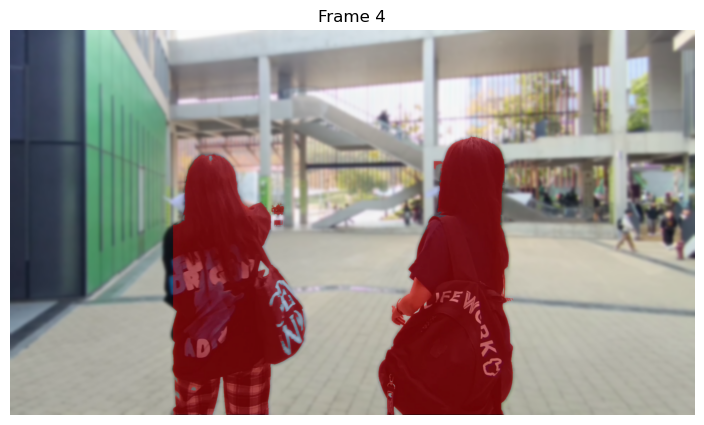

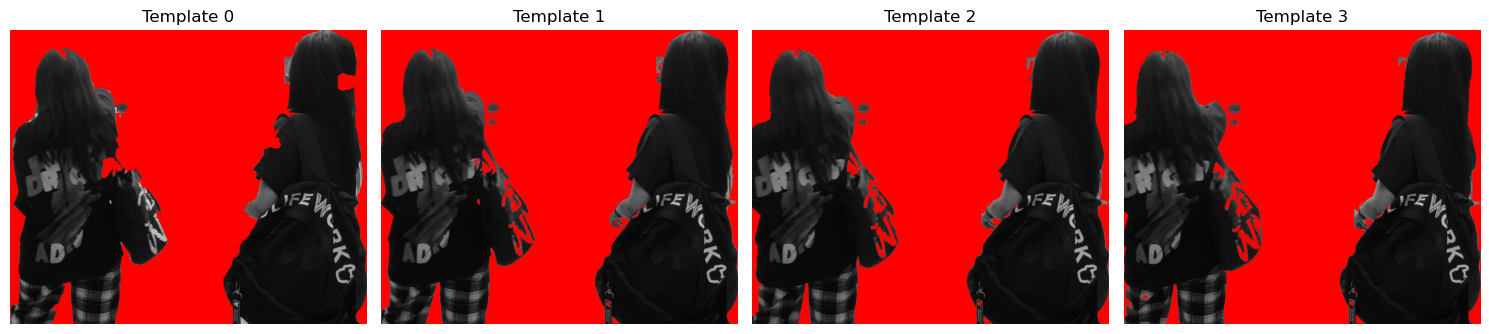

[find_best_match] Matching with templates in template bank...
[find_best_match] Current best NCC score: 0.5933
[Frame 5] Max match score: 0.593
  ↪ Object tracked at (460, 291, 953, 787)


KeyboardInterrupt: 

In [29]:
template_bank = []

video_path = "../../data/personal/videos/paperplane.mp4"
template_path = "../../outputs/segmented/paperplane_segmented.png"
'''
video_path = "../../data/DAVIS/videos/kite-walk.mp4"
template_path = "../../outputs/segmented/kite_walk_segmented.png"
'''

output_path = "../../outputs/blurred/blur_output.mp4"

dynamic_template_matching(
    video_path=video_path,
    initial_template_path=template_path,
    output_path=output_path,
)